In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# read splits from disk
with open("../artifacts/data/metadata/splits.json", "r") as f:
    splits = json.load(f)

## Load the image

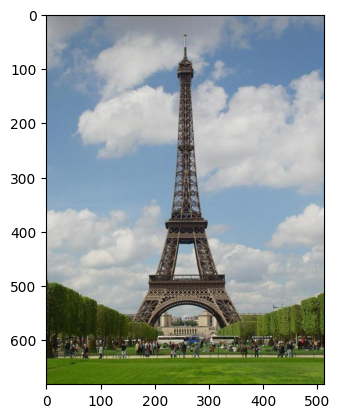

In [3]:
index = 1650
image_filename = splits["train"][index] + ".jpg"
image_path = '../artifacts/data/ADEChallengeData2016/images/training/' + image_filename
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Convert to Grayscale

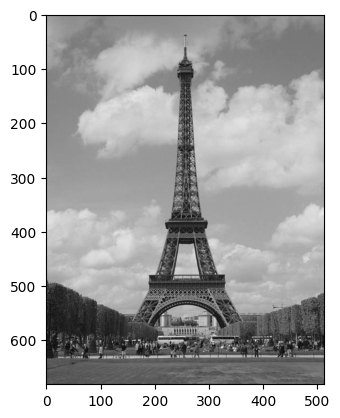

In [4]:
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

## Thresholding

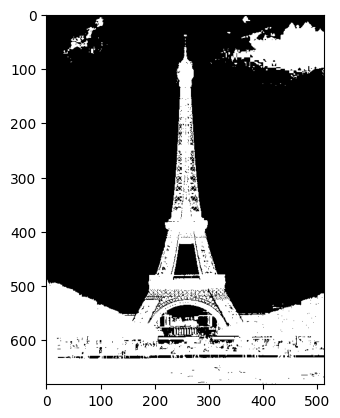

In [5]:
# apply threshold
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

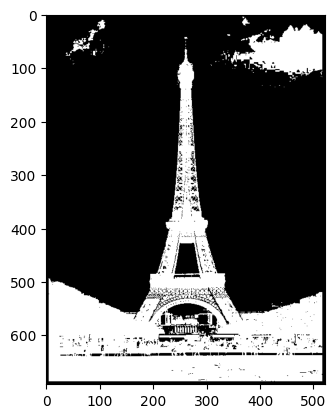

In [6]:
# pad the image to avoid edge effects
padded = cv2.copyMakeBorder(thresh, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
plt.imshow(padded, cmap='gray')

## Contours 

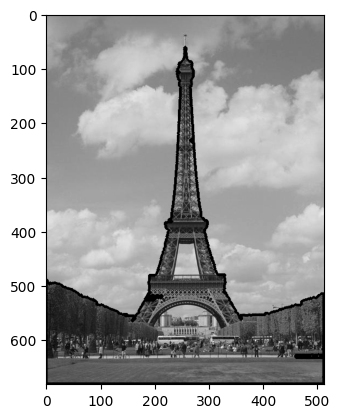

In [7]:
# find contours
contours, hierarchy = cv2.findContours(padded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# get the largest contour
contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

# remove the padding
biggest_contour = biggest_contour - 5


# draw the largest contour
image_with_contours = cv2.drawContours(gray, [biggest_contour], -1, (0, 255, 0), 3)
plt.imshow(image_with_contours, cmap='gray')

## Convert Contour to Mask

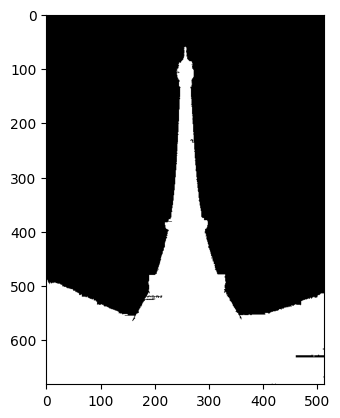

In [8]:
# draw the largest contour white on black
mask = np.zeros(image.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, [biggest_contour], -1, (255, 255, 255), -1)
plt.imshow(mask, cmap='gray')

## Gaussian Blur

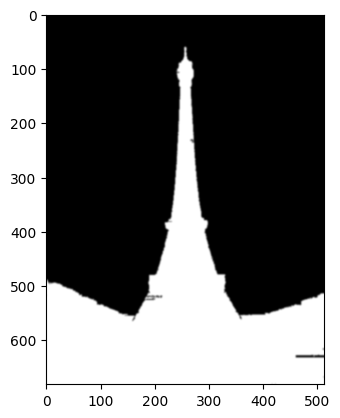

In [9]:
# apply gaussian blur
blur = cv2.GaussianBlur(mask, (7, 7), 0)
plt.imshow(blur, cmap='gray')

## Thresholding

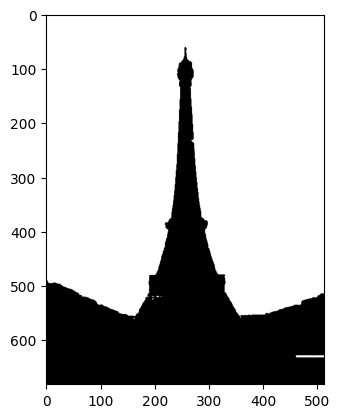

In [10]:
# apply threshold
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

## Apply opening to remove noise

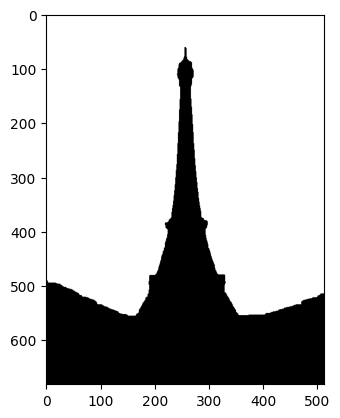

In [11]:
# apply opening to remove noise
kernel = np.ones((3, 3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 4)
plt.imshow(opening, cmap='gray')


## Extract the sky region

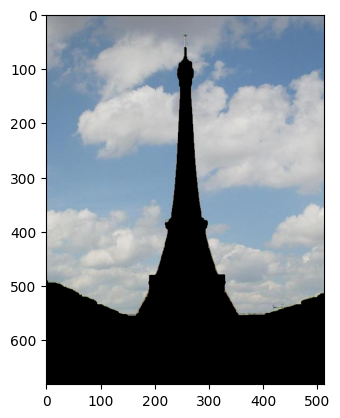

In [12]:
res = cv2.bitwise_and(image, image, mask=opening)
plt.imshow(res)

## Apply full algo

In [13]:
from sky_segmentation.image_processing.segmentation import ContourBasedSkySegmentation

In [14]:
segmentation_model = ContourBasedSkySegmentation()

In [15]:
mask = segmentation_model(image_path=image_path)

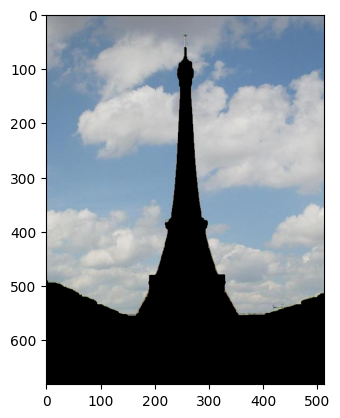

In [16]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
res = cv2.bitwise_and(image, image, mask=(mask*255).astype(np.uint8))
plt.imshow(res)